## Implementación no oficial del algoritmo del artículo: "Development and preliminary validation of an automatic digital analysis system for anima fibre analysis"


In [11]:
from skimage import img_as_bool, io, color, morphology
import matplotlib.pyplot as plt
import cv2
from utils import pruning, getSkeletonIntersection, removeCross
import numpy as np
import math
import sys
from hough_utils import *

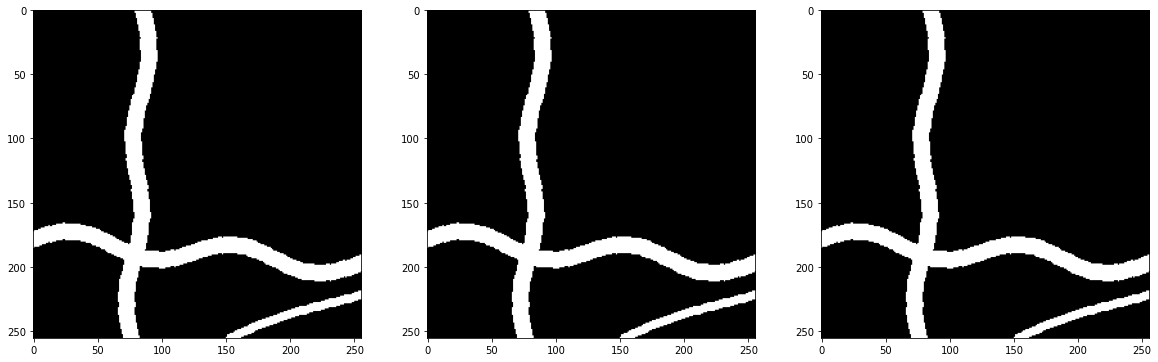

In [12]:
imgPath = "_sample.png"

rgb_img = cv2.imread(imgPath)
gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
_,bin_img = cv2.threshold(gray_img,127,255,cv2.THRESH_BINARY)

# print(bin_img.dtype)
# print(bin_img.max())

plt.figure(figsize=(20,10))
plt.subplot(131), plt.imshow(rgb_img)
plt.subplot(132), plt.imshow(gray_img, cmap='gray')
plt.subplot(133), plt.imshow(bin_img, cmap='gray')
plt.show()

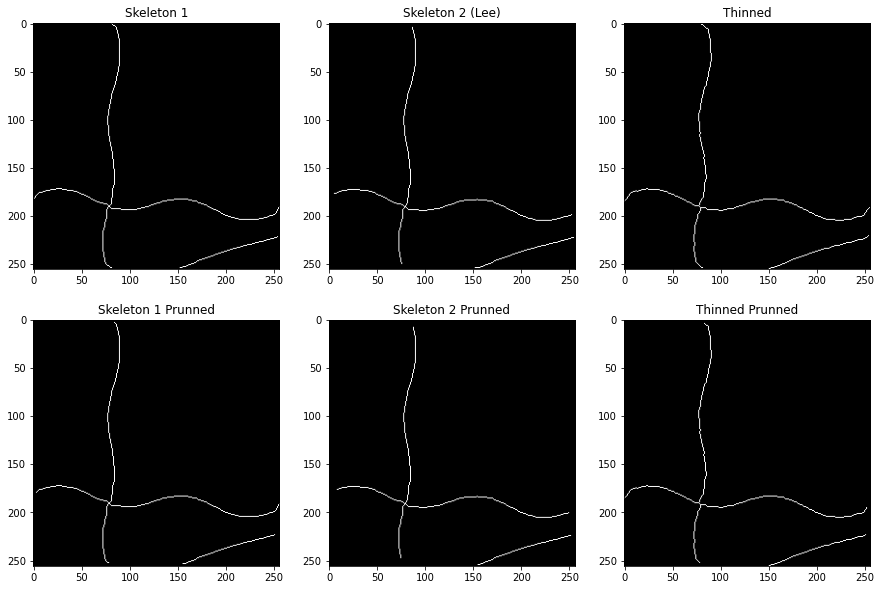

In [13]:
bin_img[bin_img==255] = 1
skeleton1 = morphology.skeletonize(bin_img)
skeleton2 = morphology.skeletonize(bin_img, method='lee')
thinned = morphology.thin(bin_img)
prunned1 = pruning(skeleton1,3)
prunned2 = pruning(skeleton2,3)
prunned3 = pruning(thinned,3)

plt.figure(figsize=(15,10))
plt.subplot(231), plt.title('Skeleton 1'), plt.imshow(skeleton1,cmap='gray')
plt.subplot(232), plt.title('Skeleton 2 (Lee)'), plt.imshow(skeleton2,cmap='gray')
plt.subplot(233), plt.title('Thinned'), plt.imshow(thinned,cmap='gray')
plt.subplot(234), plt.title('Skeleton 1 Prunned'), plt.imshow(prunned1,cmap='gray')
plt.subplot(235), plt.title('Skeleton 2 Prunned'), plt.imshow(prunned2,cmap='gray')
plt.subplot(236), plt.title('Thinned Prunned'), plt.imshow(prunned3,cmap='gray')
plt.show()

Total de líneas detectadas: 13
{12: 7, 4: 1, 11: 3, 10: 1, 5: 1}


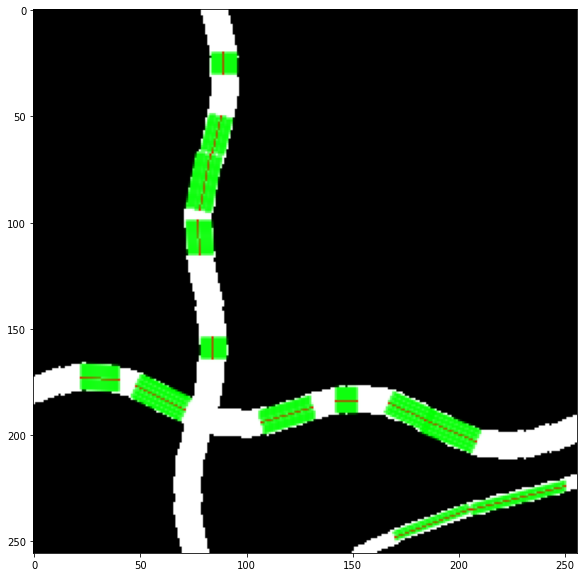

In [17]:
# Detectamos las líneas con el algoritmo de hough a partir del skeleton
skeleton = skeleton2.astype(np.uint8)
skeleton[skeleton==1] = 255

#lines = cv2.HoughLines(prunned, 1, np.pi / 180, 50, None, 0, 0)
linesP = cv2.HoughLinesP(skeleton, 1, np.pi / 180, 25, None, 10, 1)

print(f'Total de líneas detectadas: {len(linesP)}')

target = rgb_img.copy()

diametros = {}

if linesP is not None:
  for i in range(0, len(linesP)):
    # Se obtienen el punto de origen y el punto final de la línea detectada:
    l = linesP[i][0]
    # Dibujamos la línea en color rojo:
    cv2.line(target, (l[0], l[1]), (l[2], l[3]), (255,0,0), 1, cv2.LINE_8)
    # Se obtiene el ángulo de la línea detectada y el eje horizontal:
    p1 = Point(l[0], l[1])
    p2 = Point(l[2], l[3])
    angle = math.atan2(p1.y-p2.y,p1.x-p2.x)
    # Contar líneas paralelas:
    hay_linea = True
    distancia = 0 # Distancia incremental entre la línea central y las líneas paralelas
    diametro = 1 # Contador de líneas
    while hay_linea:
      distancia += 1
      # Se obtienen línea paralela con distancia positiva:
      new_p1_positive = getNewPoint(p1, angle, distancia)
      new_p2_positive = getNewPoint(p2, angle, distancia)
      point_list_positive = getPointList(new_p1_positive, new_p2_positive)
      # Se obtienen línea paralela con distancia negativa:
      new_p1_negative = getNewPoint(p1, angle, -distancia)
      new_p2_negative = getNewPoint(p2, angle, -distancia)
      point_list_negative = getPointList(new_p1_negative, new_p2_negative)
      # Verificar si las líneas paralelas estan completas:
      linea_completa_positive = esLineaCompleta(point_list_positive, bin_img)
      linea_completa_negative = esLineaCompleta(point_list_negative, bin_img)
      # Dibujar al menos una línea paralela e incrementar diametro:
      if linea_completa_positive:
        cv2.line(target, (new_p1_positive.x, new_p1_positive.y), (new_p2_positive.x, new_p2_positive.y), (0,255,0), 1, cv2.LINE_AA)
        diametro += 1
      if linea_completa_negative:
        cv2.line(target, (new_p1_negative.x, new_p1_negative.y), (new_p2_negative.x, new_p2_negative.y), (0,255,0), 1, cv2.LINE_AA)
        diametro += 1
      # Dejamos de contar si falta una línea paralela
      if not linea_completa_positive or not linea_completa_negative:
        hay_linea = False  
    # Agregamos y/o contamos el diametro obtenido:
    diametros[diametro] = diametros.get(diametro, 0) + 1

# Mostramos los diametros computados:
print(diametros)

# Ploteamos la imagen
plt.figure(figsize=(10,10))
plt.imshow(target)
plt.show()


42


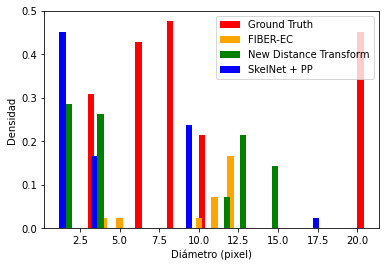

In [18]:
import random
# Mostrar histograma
#print(sum(diametros))
densities = []
x,y,x1,y1,x2,y2 = [],[],[],[],[],[]
sum_diams = sum(diametros)
print(sum_diams)
for k,v in diametros.items():
    densities.append(v / sum_diams)
    x.append(random.randint(1,20) - 0.2)
    y.append(random.randint(1,20) / sum_diams)
    x1.append(random.randint(1,20) + 0.2)
    y1.append(random.randint(1,20) / sum_diams)
    x2.append(random.randint(1,20) + 0.4)
    y2.append(random.randint(1,20) / sum_diams)
    
# plt.bar(diametros.keys(), diametros.values())
plt.bar(x1, y1, width=0.4, color='r', label='Ground Truth')
plt.bar(diametros.keys(), densities, width=0.4, color='orange', label='FIBER-EC')
plt.bar(x, y, width=0.4, color='green', label='New Distance Transform')
plt.bar(x2, y2, width=0.4, color='blue', label='SkelNet + PP')

plt.legend()

# plt.ylabel('Frecuencia')
plt.ylabel('Densidad')
plt.xlabel('Diámetro (pixel)')
plt.savefig('histograma.png')
plt.show()


In [19]:
# Se obtiene la media del diámetro
suma = 0
contador = 0
for k,v in diametros.items():
  suma += k*v
  contador += v

print('contador = ', contador)
print('promedio = ', suma / contador)

contador =  13
promedio =  10.461538461538462
